In [162]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import set_config
from sklearn.feature_selection import f_regression, f_classif, mutual_info_classif, chi2, SelectKBest
set_config(display='diagram')

## **Read data from UCI dataset**

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv', sep=',')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

After reviewing, we have made decision on the feature of `Revenue` as our targets to research in this campain.

In [4]:
df['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [5]:
y = df['Revenue'].replace({True: 1, False: 0})
X = df.drop('Revenue', axis=1)

Below, we would refer to split the data set into train set and test set with ratio of (70%, 30%) of data set. Moreover, from the train set, we continue spliting a part of it for validation set with ratio of (80%, 20%) of train set.

In [6]:
X_df, test_X_df, y_sr, test_y_sr = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.25, stratify=y_sr, random_state=0)

In [7]:
print(f"Train X set shape: {train_X_df.shape}")
print(f"Train y set shape: {train_y_sr.shape}")
print(f"Validate X set shape: {val_X_df.shape}")
print(f"Validate y set shape: {val_y_sr.shape}")
print(f"Test X set shape: {test_X_df.shape}")
print(f"Test y set shape: {test_y_sr.shape}")

Train X set shape: (6473, 17)
Train y set shape: (6473,)
Validate X set shape: (2158, 17)
Validate y set shape: (2158,)
Test X set shape: (3699, 17)
Test y set shape: (3699,)


We just `randome_state` the `train_test_split` to make the training process more efficient in general.

In [8]:
train_X_df.head().index

Int64Index([7126, 3617, 4491, 3824, 10164], dtype='int64')

In [9]:
train_X_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
7126,2,30.20,0,0.0,29,630.326667,0.006667,0.023333,0.000000,0.0,Sep,2,2,6,1,Returning_Visitor,False
3617,0,0.00,0,0.0,11,855.250000,0.018182,0.063636,0.000000,0.0,May,2,2,3,13,Returning_Visitor,False
4491,3,48.00,0,0.0,10,129.500000,0.000000,0.018182,0.000000,0.0,May,2,5,9,4,Returning_Visitor,False
3824,0,0.00,0,0.0,8,202.833333,0.000000,0.014286,0.000000,0.0,May,2,4,1,2,Returning_Visitor,False
10164,3,52.75,0,0.0,31,3069.077778,0.006452,0.020538,5.793027,0.0,Nov,1,1,3,2,Returning_Visitor,False


In [10]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_list=[], num_top_values_list=[], default=-1):
        self.num_top_values_list = num_top_values_list
        self.columns_list = columns_list
        self.default = default

    def getLogicNumberTopValue(self, X_df, column):
        counts = X_df[column].value_counts()
        return sum([1 for value in list(counts.values) if value>(1*max(list(counts.values))/100)])

    def reprocessing_data(self, X_df):
        self.columns_list = [column for column in self.columns_list if len(X_df[column].value_counts())>=5]
        if len(self.num_top_values_list)==0:
            self.num_top_values_list = [self.getLogicNumberTopValue(X_df, column) for column in self.columns_list]

    def fit(self, X_df, y=None):
        self.reprocessing_data(X_df)
        self.top_values_list = []

        for column, num_top_values in zip(self.columns_list, self.num_top_values_list):
            self.counts_ = X_df[column].value_counts()
            ids = list(self.counts_.index)
            self.top_values_list.append(ids[:max(1, min(num_top_values, len(ids)))])
        return self
    
    def transform(self, X_df, y=None):
        out_df = X_df.copy()
        for top_value, column in zip(self.top_values_list, self.columns_list):
            out_df.loc[~out_df[column].isin(top_value), column] = self.default
            out_df = out_df.sort_index(axis=1)
        return out_df

In [11]:
cate_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
nume_cols = X_df.columns.drop(cate_cols)

### a) Identify outliers

In [12]:
X_df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000
mean,2.323833,79.560976,0.510949,34.993989,31.870699,1198.888323,0.022160,0.042844,5.917538,0.062357,2.120728,2.337041,3.151894,4.099409
std,3.330882,170.278267,1.306935,142.204516,45.358193,1888.448874,0.048342,0.048401,18.508248,0.200509,0.905257,1.682179,2.397321,4.041194
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.125000,0.000000,0.014198,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,604.500000,0.003125,0.025333,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,92.100758,0.000000,0.000000,38.000000,1474.500000,0.016937,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,2657.318056,24.000000,2256.916667,705.000000,43171.233380,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


* Standard deviation method

In [13]:
data_mean, data_std = np.mean(train_X_df[nume_cols]), np.std(train_X_df[nume_cols])
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outlier_std_df = train_X_df[~((train_X_df[nume_cols] < lower) | (train_X_df[nume_cols] > upper)).any(axis=1)]
print('Percentage of outliers: ',round((1-len(outlier_std_df)/len(train_X_df))*100, 2),'%', sep='')

Percentage of outliers: 19.22%


c:\APP\Python\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


* Interquartile Range Method

In [14]:
Q1 = train_X_df[nume_cols].quantile(0.25)
Q3 = train_X_df[nume_cols].quantile(0.75)
IQR = Q3 - Q1

outlier_iqr_df = train_X_df[~((train_X_df[nume_cols] < (Q1 - 1.5 * IQR)) |(train_X_df[nume_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print('Percentage of outliers: ',round((1-len(outlier_iqr_df)/len(X_df))*100, 2),'%', sep='')

Percentage of outliers: 68.13%


The interquartile range method detects too much outliers so this is completely inefficient

In [15]:
lof = LocalOutlierFactor()
yhat = lof.fit_predict(train_X_df[nume_cols])
mask = yhat != -1
outlier_aod_df = train_X_df.iloc[mask]
outlier_aod_y_df = train_y_sr.iloc[mask]
print('Percentage of outliers: ',round((1-len(outlier_aod_df)/len(train_X_df))*100, 2),'%', sep='')

Percentage of outliers: 10.06%


This method gets low percentage of outliers that we can accept to remove

In [16]:
train_X_df = outlier_aod_df
train_y_sr = outlier_aod_y_df
train_X_df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,2.330814,74.792171,0.433184,25.339379,31.794401,1198.582692,0.021682,0.042419,4.212721,0.061560,2.119375,2.329784,3.167296,4.064411
std,3.305934,139.332081,1.147550,97.951695,42.065412,1651.625145,0.047342,0.047466,12.607227,0.199715,0.896081,1.666634,2.402364,4.012368
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,197.437500,0.000000,0.014135,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,19.000000,644.600000,0.003318,0.025517,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,94.858333,0.000000,0.000000,38.000000,1545.312500,0.017004,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,24.000000,1417.500000,14.000000,1778.000000,518.000000,14988.591510,0.200000,0.200000,154.095539,1.000000,8.000000,13.000000,9.000000,20.000000


<p>Some category columns have too many categories that will affect the model. So, we choose which columns that have more than 5 categories to process</p>

In [17]:
col_adderdropper = ColAdderDropper(columns_list=cate_cols)
col_adderdropper.fit(train_X_df)
new_train_X_df = col_adderdropper.transform(train_X_df)
new_train_X_df.head()

,Administrative,Administrative_Duration,BounceRates,Browser,ExitRates,Informational,Informational_Duration,Month,OperatingSystems,PageValues,ProductRelated,ProductRelated_Duration,Region,SpecialDay,TrafficType,VisitorType,Weekend
7126,2,30.20,0.006667,2,0.023333,0,0.0,Sep,2,0.000000,29,630.326667,6,0.0,1,Returning_Visitor,False
3617,0,0.00,0.018182,2,0.063636,0,0.0,May,2,0.000000,11,855.250000,3,0.0,13,Returning_Visitor,False
4491,3,48.00,0.000000,5,0.018182,0,0.0,May,2,0.000000,10,129.500000,9,0.0,4,Returning_Visitor,False
3824,0,0.00,0.000000,4,0.014286,0,0.0,May,2,0.000000,8,202.833333,1,0.0,2,Returning_Visitor,False
10164,3,52.75,0.006452,1,0.020538,0,0.0,Nov,1,5.793027,31,3069.077778,3,0.0,2,Returning_Visitor,False


## Preprocessing Pipeline

- `Preprocessing`: in here, input data would be treated by seperating into numeric and categorical data. After spliting, both of them would be fill up **Missing Values** with the MEAN for the numeric and MOST_FREQUENCY for categorical. In addition, categorical would be encoding by `OneHotEncoder`.

In [18]:
numerics_trans = SimpleImputer()
categorical_trans=make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

column_trans = make_column_transformer(
    (numerics_trans, nume_cols),
    (categorical_trans, cate_cols)
)

preprocess_pipeline = make_pipeline(col_adderdropper, column_trans, StandardScaler(with_mean=False))
preprocess_train_X = preprocess_pipeline.fit_transform(train_X_df)
preprocess_pipeline

Pipeline(steps=[('coladderdropper',
                 ColAdderDropper(columns_list=['Month', 'OperatingSystems',
                                               'Browser', 'Region',
                                               'TrafficType'],
                                 num_top_values_list=[10, 5, 8, 9, 13])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRel...
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'],
      dtype='object')),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Month', 'OperatingSystems',
                                                   'Browser', 'Region',
                                                   'TrafficType', 'VisitorType',
                                                   'Weekend'])])),
                ('standardscaler', StandardScaler(with_mean=False))])

In [ ]:
def plot_grid_search(grid_search, grid_params):
    scores = np.array(grid_search.cv_results_['mean_test_score']).reshape(len(grid_params[list(grid_params.keys())[0]]), len(grid_params[list(grid_params.keys())[1]]))
    for score, param in zip(scores, grid_params[list(grid_params.keys())[0]]):
        plt.plot(grid_params[list(grid_params.keys())[1]], score, '-o', label=param)
    plt.legend(loc='lower left')
    plt.xlabel(list(grid_params.keys())[1])
    plt.ylabel('Accuracy')

<h1>1st Model: Classification using Neural Network</h1>

Problem: With the given features, detecting the crucial ones then build up modeling for the classification of these features into Revenue-Rewards

Pipline architecture: Along including Preprocessing Pipeline, there are 2 more:
- `Selecting Best Features`: in this step, data would filtered in order to reduce the dimension of data by using `Chi2-Algorithms`. The number of features kept would be defined by manually or by grid search later.
- `MLP Classifier`: using Neural Network method, this step would start to learning through the preprocessed data and spride out the ACCURACY of this model after training.

In [23]:
full_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('selectkbest', SelectKBest(chi2, k=10)),
    ('mlpclassifier', MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', random_state=0, learning_rate_init=0.05, alpha=100, max_iter=1000))
])
full_pipeline

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('coladderdropper',
                                  ColAdderDropper(columns_list=['Month',
                                                                'OperatingSystems',
                                                                'Browser',
                                                                'Region',
                                                                'TrafficType'],
                                                  num_top_values_list=[10, 5, 8,
                                                                       9,
                                                                       13])),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('simpleimputer',
                                                                   SimpleImputer(),
                                                                   Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Infor...
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Month',
                                                                    'OperatingSystems',
                                                                    'Browser',
                                                                    'Region',
                                                                    'TrafficType',
                                                                    'VisitorType',
                                                                    'Weekend'])])),
                                 ('standardscaler',
                                  StandardScaler(with_mean=False))])),
                ('selectkbest',
                 SelectKBest(score_func=<function chi2 at 0x000002376ED070A0>)),
                ('mlpclassifier',
                 MLPClassifier(alpha=100, hidden_layer_sizes=50,
                               learning_rate_init=0.05, max_iter=1000,
                               random_state=0))])

In [157]:
full_pipeline.fit(train_X_df, train_y_sr)
train_acc = full_pipeline.score(train_X_df, train_y_sr)*100
val_acc = full_pipeline.score(val_X_df, val_y_sr)*100
print(f'With the above model pipeline we get the accuracy of train: {train_acc.round(3)} and validate: {val_acc.round(3)}')

With the above model pipeline we get the accuracy of train: 86.62 and validate: 84.523


Due to the defined paramaters of Neural Network, in which include `hidden_layer_sizes=(50), activation='relu', solver='adam', random_state=0, learning_rate_init=0.05, alpha=100, max_iter=1000`, we got the final accuracy was: <h5>84.523%</h5>

After training the model we got the accuracy is 84.5%, this score still be pretty unacceptable so in next we tend to innovate our current model by using grid search method

In [130]:
optimize_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('selectkbest', SelectKBest(chi2)),
    ('mlpclassifier', MLPClassifier(hidden_layer_sizes=(50), solver='adam', activation='relu', random_state=0, learning_rate_init=0.05, max_iter=1000))
])

param_grid = {'mlpclassifier__activation': ['logistic', 'relu', 'softmax', 'tanh'],
            'selectkbest__k': [3, 5, 7, 9, 11, 14, 'all']}

grid_search = GridSearchCV(optimize_pipeline, param_grid)
grid_search.fit(train_X_df, train_y_sr)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('coladderdropper',
                                                         ColAdderDropper(columns_list=['Month',
                                                                                       'OperatingSystems',
                                                                                       'Browser',
                                                                                       'Region',
                                                                                       'TrafficType'],
                                                                         num_top_values_list=[10,
                                                                                              5,
                                                                                              8,
                                                                                              9,
                                                                                              13])),
                                                        ('columntransformer',
                                                         ColumnTransformer(transformers=[('simpleimputer',
                                                                                          SimpleImputer(),
                                                                                          Index(['Administrative', 'Administrative_Duration'...
                                                                                           'Weekend'])])),
                                                        ('standardscaler',
                                                         StandardScaler(with_mean=False))])),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function chi2 at 0x000002376ED070A0>)),
                                       ('mlpclassifier',
                                        MLPClassifier(hidden_layer_sizes=50,
                                                      learning_rate_init=0.05,
                                                      max_iter=1000,
                                                      random_state=0))]),
             param_grid={'mlpclassifier__activation': ['logistic', 'relu',
                                                       'tanh'],
                         'selectkbest__k': [3, 5, 7, 9, 11, 14, 'all']})

In [195]:
grid_search.score(test_X_df, test_y_sr)

0.8994322789943228

In [139]:
val_acc = grid_search.score(val_X_df, val_y_sr)*100
print(f'With the grid searching, we found a better accuracy for the model with {val_acc.round(3)}%')
print(f'With paramas is {grid_search.best_params_}')

With the grid searching, we found a better accuracy for the model with 90.964%
With paramas is {'mlpclassifier__activation': 'relu', 'selectkbest__k': 7}


After using grid search for innovating model, we defined that the best activation was RELU and the number of features should be kept was 7 features. In which the accuracy was converging at **90.9%**

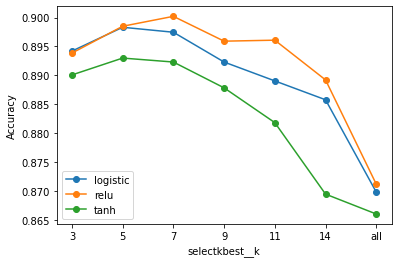

In [145]:
plot_grid_search(grid_search, param_grid)

<h1>Classification using decision tree</h1>

In [189]:
tree_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('selectkbest', SelectKBest(chi2, k=7)),
    ('decisiontree', DecisionTreeClassifier(random_state=0, max_depth=10))
])
tree_pipeline

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('coladderdropper',
                                  ColAdderDropper(columns_list=['Month',
                                                                'OperatingSystems',
                                                                'Browser',
                                                                'Region',
                                                                'TrafficType'],
                                                  num_top_values_list=[10, 5, 8,
                                                                       9,
                                                                       13])),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('simpleimputer',
                                                                   SimpleImputer(),
                                                                   Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Infor...
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Month',
                                                                    'OperatingSystems',
                                                                    'Browser',
                                                                    'Region',
                                                                    'TrafficType',
                                                                    'VisitorType',
                                                                    'Weekend'])])),
                                 ('standardscaler',
                                  StandardScaler(with_mean=False))])),
                ('selectkbest',
                 SelectKBest(k=7,
                             score_func=<function chi2 at 0x000002376ED070A0>)),
                ('decisiontree',
                 DecisionTreeClassifier(max_depth=10, random_state=0))])

In [190]:
tree_pipeline.fit(train_X_df, train_y_sr)
tree_pipeline.score(val_X_df, val_y_sr)*100
# r = export_text(clf, feature_names=list(nume_cols))
# print(r)

88.1371640407785

In [194]:
chi2(train_X_df[nume_cols], train_y_sr)[1]

array([6.00370999e-196, 0.00000000e+000, 1.63710622e-047, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 1.03049039e-003, 1.01849623e-003,
       0.00000000e+000, 1.90815166e-005])